In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import GprModel
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import skgstat as skg
from skgstat import Variogram, OrdinaryKriging

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Experiment results for all 6 features (precip is removed)
# with fixed GPR model

In [3]:
plt.rcParams.update({'font.size': 16})

In [4]:
def subsample_data(data, sample_size = 10000):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    
    return indices

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

In [16]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers for GP only, other models are saved
# GPR is a interpolation method, no need to record traning data.
gpr_martern_test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        # Reshape the data per time stamp
        flatten_train_x_reshaped = flatten_train_x.reshape(20,-1, flatten_train_x.shape[-1])
        flatten_train_y_reshaped = flatten_train_y.reshape(20,-1, flatten_train_y.shape[-1])
        
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
         # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
              
        test_results_fold = []
        
        gpr_models = []
        for i in range(0, number_of_folds):            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
            indices = np.random.choice(flatten_train_x_reshaped.shape[1], 200, replace=False)
            
            kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
            gpr_train_x = np.vstack(flatten_train_x_reshaped[:,indices,:])
            gpr_train_y = np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1))
            
            gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(gpr_train_x, gpr_train_y)
            
            pred = gpr_model.predict(flatten_test_x, return_std=False)
            rmse = mean_squared_error(pred, flatten_test_y, squared=False)
            test_results_fold.append({'gpr_test' : rmse})
            print(rmse)
            
        #After all folds are done, update the result containers
        gpr_martern_test_results.append(test_results_fold)
        

In [17]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations
7.660400456465422
Currently running fold 1 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


8.542549572126385
Currently running fold 2 for 1 stations
8.194662278116873
Currently running fold 3 for 1 stations
8.518085400337203
Currently running fold 4 for 1 stations
8.501811207781246
Currently running fold 5 for 1 stations
7.706405814581691
Currently running fold 6 for 1 stations
7.770692872891377
Currently running fold 7 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


8.567250807118144
Currently running fold 8 for 1 stations
7.850805411666944
Currently running fold 9 for 1 stations
7.917860403096453
Currently running fold 0 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.20166904524774
Currently running fold 1 for 2 stations
16.074903645151977
Currently running fold 2 for 2 stations
11.971552405244879
Currently running fold 3 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


11.998794324487777
Currently running fold 4 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.10357904068339
Currently running fold 5 for 2 stations
12.09989618390119
Currently running fold 6 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.181172309320175
Currently running fold 7 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


12.11094489199445
Currently running fold 8 for 2 stations
9.569191917024652
Currently running fold 9 for 2 stations
11.831785396962676
Currently running fold 0 for 3 stations
15.944553930660145
Currently running fold 1 for 3 stations
15.988963361783338
Currently running fold 2 for 3 stations
15.971476751268314
Currently running fold 3 for 3 stations
15.990718798983506
Currently running fold 4 for 3 stations
15.960218132472017
Currently running fold 5 for 3 stations
15.876495277888226
Currently running fold 6 for 3 stations
16.060958959459004
Currently running fold 7 for 3 stations
15.917259565979384
Currently running fold 8 for 3 stations
15.922603856276824
Currently running fold 9 for 3 stations
15.978424008835443
Currently running fold 0 for 4 stations
17.53639639748729
Currently running fold 1 for 4 stations
17.536993329089636
Currently running fold 2 for 4 stations
17.522647912963723
Currently running fold 3 for 4 stations
17.529973780303408
Currently running fold 4 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


18.049885023040403
Currently running fold 7 for 5 stations
8.009682715795702
Currently running fold 8 for 5 stations
8.061080402091811
Currently running fold 9 for 5 stations
8.002015856629749
Currently running fold 0 for 6 stations
7.681535105106876
Currently running fold 1 for 6 stations
8.04781361193188
Currently running fold 2 for 6 stations
7.562059733369519
Currently running fold 3 for 6 stations
7.667519405542956
Currently running fold 4 for 6 stations
7.928868616870263
Currently running fold 5 for 6 stations
7.686959382385399
Currently running fold 6 for 6 stations
7.888997134867886
Currently running fold 7 for 6 stations
7.620018514243994
Currently running fold 8 for 6 stations
7.385330131754799
Currently running fold 9 for 6 stations
7.738826726144609
Currently running fold 0 for 7 stations
7.722160900405399
Currently running fold 1 for 7 stations
7.5955149456012085
Currently running fold 2 for 7 stations
7.6796532831727955
Currently running fold 3 for 7 stations
7.4316815926

In [23]:
gpr_martern_test_results_min_feature

[[{'gpr_test': 7.660400456465422},
  {'gpr_test': 8.542549572126385},
  {'gpr_test': 8.194662278116873},
  {'gpr_test': 8.518085400337203},
  {'gpr_test': 8.501811207781246},
  {'gpr_test': 7.706405814581691},
  {'gpr_test': 7.770692872891377},
  {'gpr_test': 8.567250807118144},
  {'gpr_test': 7.850805411666944},
  {'gpr_test': 7.917860403096453}],
 [{'gpr_test': 16.20166904524774},
  {'gpr_test': 16.074903645151977},
  {'gpr_test': 11.971552405244879},
  {'gpr_test': 11.998794324487777},
  {'gpr_test': 16.10357904068339},
  {'gpr_test': 12.09989618390119},
  {'gpr_test': 16.181172309320175},
  {'gpr_test': 12.11094489199445},
  {'gpr_test': 9.569191917024652},
  {'gpr_test': 11.831785396962676}],
 [{'gpr_test': 15.944553930660145},
  {'gpr_test': 15.988963361783338},
  {'gpr_test': 15.971476751268314},
  {'gpr_test': 15.990718798983506},
  {'gpr_test': 15.960218132472017},
  {'gpr_test': 15.876495277888226},
  {'gpr_test': 16.060958959459004},
  {'gpr_test': 15.917259565979384},
  {'g

In [20]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

#%store gpr_martern_test_results_min_feature

#closing seesion, restarting kernel

# %store -r training_results_li_ts_km_nn_full_feature
#%store -r test_results_li_ts_km_nn_min_feature

In [26]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

gar matern
8.1231±0.3614
gar matern
13.4143±2.3353
gar matern
15.9612±0.0478
gar matern
17.5325±0.0076
gar matern
11.0851±4.5122
gar matern
7.7208±0.1823
gar matern
7.6218±0.1602
gar matern
7.3792±0.075
gar matern
7.3674±0.1706
gar matern
7.234±0.1185
gar matern
7.2004±0.1067
gar matern
7.0915±0.1051
exp
linear
7.332799911499023±0.0
nn
7.123±0.0051
fcm
7.0657±0.0085
kmeans
7.058599948883057±0.014600000344216824
kmeans min
7.019100189208984
exp
linear
7.180799961090088±0.0
nn
6.4±0.0313
fcm
6.4703±0.0145
kmeans
6.428599834442139±0.032099999487400055
kmeans min
6.38070011138916
exp
linear
7.0304999351501465±0.0
nn
5.9292±0.0098
fcm
6.0618±0.0077
kmeans
6.087699890136719±0.020999999716877937
kmeans min
6.054999828338623
exp
linear
6.915299892425537±0.0
nn
5.7671±0.0033
fcm
5.8669±0.0092
kmeans
340.2807922363281±823.5894165039062
kmeans min
5.868299961090088
exp
linear
6.783999919891357±0.0
nn
5.6984±0.0025
fcm
5.8032±0.0092
kmeans
178.58889770507812±428.5433044433594
kmeans min
5.81510019

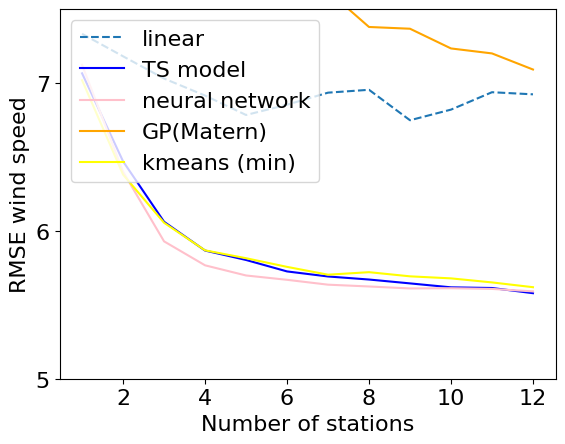

In [22]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
gpr_matern_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_min_feature:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
# for exp in gpr_test_results[0:12]:
#     gpr_test_plot.append(exp['gpr_test'])

for exp in gpr_martern_test_results_min_feature:
    print('gar matern')
    print(f"{np.round(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]), 4)}±{np.round(np.std([d['gpr_test'] for d in exp if 'gpr_test' in d]),4)}")
    gpr_matern_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
#plt.plot(x_axis, gpr_test_plot, label='GP(RBF)', c='red')
plt.plot(x_axis, gpr_matern_test_plot, label='GP(Matern)', c='orange')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in test_results_li_ts_km_nn_min_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 
    print('kmeans min')
    print(f"{np.round(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}")
 